# 瓦片中的连通分量标记
在瓦片中标记对象是一项具有挑战性的任务。如果无法避免这一步骤，[dask-image](http://image.dask.org/en/latest/)提供了合适的功能来获取跨多个瓦片的标记图像。

In [1]:
import numpy as np
import dask
import dask.array as da
from skimage.data import cells3d
from skimage.io import imread
from skimage.measure import label as skimage_label
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from dask_image.ndmeasure import label as daskimage_label

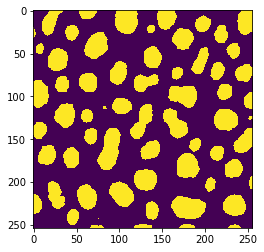

In [2]:
image = imread("../../data/blobs.tif") > 128
imshow(image)

In [3]:
tiles = da.from_array(image, chunks=(128, 128))
tiles

dask.array<array, shape=(254, 256), dtype=bool, chunksize=(128, 128), chunktype=numpy.ndarray>

我们将使用scikit-image的`label()`函数来处理我们的图像。

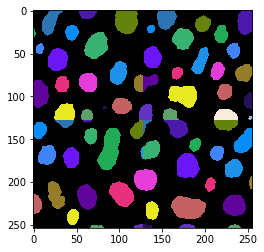

In [4]:
procedure = skimage_label

tile_map = da.map_blocks(procedure, tiles)

result = tile_map.compute()
imshow(result, labels=True)

在这张图像中，我们已经可以看到结果在图像水平和垂直中心的瓦片边界处有伪影。为了进一步检查结果，我们将计算不分瓦片的图像连通分量标记。

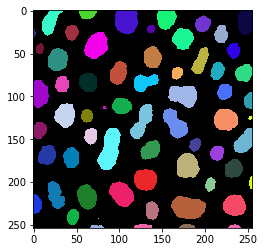

In [5]:
reference = skimage_label(image)

imshow(reference, labels=True)

接下来，我们可以比较标记图像中的最大强度，看看这两个图像中的标记总数是否相等。它们不相等：

In [6]:
result.max(), reference.max()

(20, 63)

通过计算结果图像中像素强度的标准差（按参考标记分组），我们可以可视化哪些对象没有被正确分割。

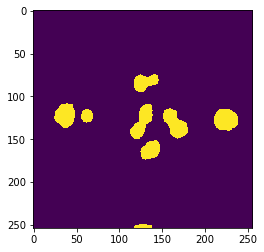

In [7]:
stddev_map = cle.standard_deviation_intensity_map(result, reference) > 0

imshow(stddev_map)

## 使用dask-image进行瓦片连通分量标记
图像处理库dask-image提供了一个分布式版本的连通分量标记功能[dask_image.ndmeasure.label](http://image.dask.org/en/latest/dask_image.ndmeasure.html?highlight=label#dask_image.ndmeasure.label)：

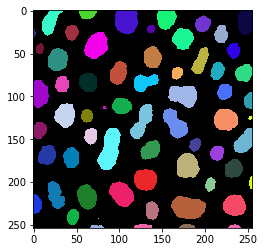

In [8]:
result_di, num_labels = daskimage_label(image)

imshow(result_di, labels=True)

注意，这个操作的结果是一个dask数组，计算最大值等操作并不直观：

In [9]:
result_di.max(), reference.max()

(dask.array<amax-aggregate, shape=(), dtype=int32, chunksize=(), chunktype=numpy.ndarray>,
 63)

In [10]:
np.asarray(result_di).max(), reference.max()

(63, 63)